In [1]:
#!pip install keras-tuner
#!pip install --upgrade tensorflow

import os
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner import HyperModel, RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns

C:\Users\tab\AppData\Local\Temp\ipykernel_27652\2600087072.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


## Read trips dataset and external data

In [2]:
# Replace this with user folder path to datasets
folder_path = '/Users/tab/Documents/R/MScA/2024/Capstone Project'

In [3]:
# List of files
files = [
    'Chicago_Weather.csv',
    'Weekly_Gas_Prices_Abridged.csv',
    'Weekly_Gas_Prices.csv',
    'E_Scooter_Trips.csv',
    'Chicago_Crimes.csv',
    'Race_and_Ethnicity',
    'Citizenship.csv',
    'Education.csv',
    'Housing.csv',
    'Poverty.csv',
    'Health_Insurance_Coverage.csv',
    'Income.csv'
]

# Function to read a file and print its columns
def print_column_names(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        print(f"File format not supported for {file_path}")
        return
    print(f"Columns in {os.path.basename(file_path)}: {df.columns.tolist()}")

# Iterate over the files, read each one, and print column names
for file in files:
    file_path = os.path.join(folder_path, file)
    print_column_names(file_path)

Columns in Chicago_Weather.csv: ['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']
Columns in Weekly_Gas_Prices_Abridged.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in Weekly_Gas_Prices.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in E_Scooter_Trips.csv: ['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration', 'Vendor', 'Start Community Area Number', 'End Community Area Number', 'Start Community Area Name', 'End Community Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude'

In [4]:
# Trips data
df_e_scooter_trips = pd.read_csv('E_Scooter_Trips.csv')

# Weather data
df_weather = pd.read_csv('Chicago_Weather.csv')

# Crime data
df_crimes = pd.read_csv('Chicago_Crimes.csv')

# Gas data
df_gas = pd.read_csv('Weekly_Gas_Prices_Abridged.csv')

# Race and Ethnicity
df_race = pd.read_csv('Race_and_Ethnicity.csv')

# Citizenship
df_citizenship = pd.read_csv('Citizenship.csv')

# Education
df_education = pd.read_csv('Education.csv')

# Housing
df_housing = pd.read_csv('Housing.csv')

# Poverty
df_poverty = pd.read_csv('Poverty.csv')

# Health Insurance Coverage
df_insurance = pd.read_csv('Health_Insurance_Coverage.csv')

# Income
df_income = pd.read_csv('Income.csv')

print(f'Trips Dataset: {df_e_scooter_trips.shape}\nWeather Data: {df_weather.shape}' +
'\nCrime Data: {df_crimes.shape}\nGas Data: {df_gas.shape}' +
'\nRace Data: {df_race.shape}\nIncome Data: {df_income.shape}')

Trips Dataset: (3797237, 16)
Weather Data: (514, 33)
Crime Data: {df_crimes.shape}
Gas Data: {df_gas.shape}
Race Data: {df_race.shape}
Income Data: {df_income.shape}


In [5]:
# Function to quickly inspect the datasets
def inspect_data(df, name):
    print(f"--- Inspecting {name} ---")
    print("First few rows:")
    print(df.head())
    print("\nSummary Statistics:")
#     print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print(df.info())
    print("\n")

In [6]:
# Inspect each dataset
inspect_data(df_weather, "Weather Data")
inspect_data(df_gas, "Gas Prices Data")
inspect_data(df_e_scooter_trips, "E-Scooter Trips Data")
inspect_data(df_crimes, "Crimes Data")
inspect_data(df_race, "Community Areas Race Data")
inspect_data(df_citizenship, "Citizenship Status Data")
inspect_data(df_education, "Education Level Data")
inspect_data(df_housing, "Housing Occupancy Data")
inspect_data(df_poverty, "Poverty Data")
inspect_data(df_insurance, "Insurance Data")
inspect_data(df_income, "Community Areas Income Data")

--- Inspecting Weather Data ---
First few rows:
                    name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Chicago,United States  2022-05-05     52.9     44.3  49.7          52.9   
1  Chicago,United States  2022-05-06     52.7     49.7  51.1          52.7   
2  Chicago,United States  2022-05-07     64.5     47.6  55.9          64.5   
3  Chicago,United States  2022-05-08     66.9     45.7  58.3          66.9   
4  Chicago,United States  2022-05-09     83.5     57.1  70.8          83.3   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0          40.5       48.8  42.7      76.8  ...          3.5        1   
1          45.1       50.9  45.2      81.4  ...          2.1        1   
2          43.9       55.5  31.4      40.6  ...         19.0        9   
3          43.8       57.8  38.8      48.8  ...          8.5        4   
4          57.1       70.8  50.8      49.6  ...         13.9        7   

   severerisk              sunrise          

Trip ID                           0
Start Time                        0
End Time                          0
Trip Distance                     0
Trip Duration                     0
Vendor                            0
Start Community Area Number    2827
End Community Area Number      3941
Start Community Area Name      2827
End Community Area Name        3941
Start Centroid Latitude        2827
Start Centroid Longitude       2827
Start Centroid Location        2827
End Centroid Latitude          3941
End Centroid Longitude         3941
End Centroid Location          3941
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797237 entries, 0 to 3797236
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Trip ID                      object 
 1   Start Time                   object 
 2   End Time                     object 
 3   Trip Distance                int64  
 4   Trip Duration                int64  
 5  

## Data Cleaning

### Crimes Dataset

In [7]:
# Handling missing values in the Crimes dataset
# Fill missing coordinates and location with NaN
df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']] = df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']].replace(0, np.nan)

# For 'Location Description', 'District', 'Ward', and 'Community Area', we will fill missing values with a placeholder
df_crimes['Location Description'] = df_crimes['Location Description'].fillna('Unknown')
df_crimes['District'] = df_crimes['District'].fillna('Unknown')
df_crimes['Ward'] = df_crimes['Ward'].fillna('Unknown')
df_crimes['Community Area'] = df_crimes['Community Area'].fillna('Unknown')

# Dropping rows where essential coordinates are missing since they are crucial for spatial analysis
df_crimes.dropna(subset=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], inplace=True)

In [8]:
df_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"
6,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"


### Race Dataset

In [9]:
df_race.head()

,community_area_number,community_name,total_population,asian,black,hispanic,white,other,asian_percent,black_percent,hispanic_percent,white_percent,other_percent
0,1,Rogers Park,"55,643","3,018","15,059","10,537","24,644","2,385",0.054239,0.270636,0.189368,0.442895,0.042863
1,2,West Ridge,"78,763","16,556","9,166","15,514","33,123","4,404",0.210200,0.116374,0.196971,0.420540,0.055915
2,3,Uptown,"59,453","6,173","10,752","8,911","31,611","2,006",0.103830,0.180849,0.149883,0.531697,0.033741
3,4,Lincoln Square,"41,350","3,771","1,234","7,373","26,590","2,382",0.091197,0.029843,0.178307,0.643047,0.057606
4,5,North Center,"36,142","2,156",923,"4,323","27,005","1,735",0.059654,0.025538,0.119612,0.747192,0.048005


In [10]:
# Cleaning the Race dataset
# Rename columns for clarity -- [TAB] dataset changed, this is no longer necessary. Commented out for now.
#df_race.rename(columns={'Race and Ethnicity in Chicago Community Areas': 'Community Area', 'Unnamed: 1': 'Data'}, inplace=True)
#df_race

In [11]:
# Include cleaning up of race dataset here
df_race

,community_area_number,community_name,total_population,asian,black,hispanic,white,other,asian_percent,black_percent,hispanic_percent,white_percent,other_percent
0,1,Rogers Park,"55,643","3,018","15,059","10,537","24,644","2,385",0.054239,0.270636,0.189368,0.442895,0.042863
1,2,West Ridge,"78,763","16,556","9,166","15,514","33,123","4,404",0.210200,0.116374,0.196971,0.420540,0.055915
2,3,Uptown,"59,453","6,173","10,752","8,911","31,611","2,006",0.103830,0.180849,0.149883,0.531697,0.033741
3,4,Lincoln Square,"41,350","3,771","1,234","7,373","26,590","2,382",0.091197,0.029843,0.178307,0.643047,0.057606
4,5,North Center,"36,142","2,156",923,"4,323","27,005","1,735",0.059654,0.025538,0.119612,0.747192,0.048005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,"26,940",47,"25,722",393,451,327,0.001745,0.954788,0.014588,0.016741,0.012138
73,74,Mount Greenwood,"18,840",303,609,"1,975","15,287",666,0.016083,0.032325,0.104830,0.811412,0.035350
74,75,Morgan Park,"20,526",86,"12,607",910,"6,237",686,0.004190,0.614197,0.044334,0.303859,0.033421
75,76,O'Hare,"13,285","2,096",892,"1,091","8,921",285,0.157772,0.067143,0.082123,0.671509,0.021453


### Weather Dataset

In [12]:
df_weather.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [13]:
# Include cleaning up of weather dataset here
df_weather = df_weather[['datetime', 'temp', 'precip', 'snow']]

### Gas Dataset

In [14]:
# Include cleaning up of gas dataset here
df_gas

,Date,"Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices (Dollars per Gallon)"
0,5/2/2022,4.467
1,5/9/2022,4.672
2,5/16/2022,4.929
3,5/23/2022,5.133
4,5/30/2022,5.264
...,...,...
70,9/4/2023,4.189
71,9/11/2023,4.108
72,9/18/2023,4.068
73,9/25/2023,3.962


### Income Dataset

- We define low income as earning below 40,000.
- We define high income as earning above 130,000.

In [15]:
# Include cleaning up of income dataset here 
df_income

,community_area_number,community_name,total_population,median_household_income,low_income,middle_income,high_income,below_10_income,10_to_15_income,15_to_20_income,...,35_to_40_income_percent,40_to_45_income_percent,45_to_50_income_percent,50_to_60_income_percent,60_to_75_income_percent,75_to_100_income_percent,100_to_125_income_percent,125_to_150_income_percent,150_to_200_income_percent,above_200_income_percent
0,1,Rogers Park,24916,46164,10925,11113,2878,2652,1836,1097,...,0.055025,0.053058,0.034034,0.078584,0.084524,0.123936,0.071882,0.041018,0.040616,0.033874
1,2,West Ridge,25869,57621,8498,12503,4868,1447,1039,1200,...,0.044880,0.050833,0.043836,0.096795,0.096641,0.116781,0.078434,0.056322,0.063358,0.068499
2,3,Uptown,30970,57576,11102,13694,6174,3200,1838,1286,...,0.037359,0.036067,0.038683,0.084759,0.090701,0.118728,0.073232,0.060510,0.070520,0.068324
3,4,Lincoln Square,18481,79696,4218,8901,5362,768,329,417,...,0.034847,0.040799,0.045560,0.061090,0.092636,0.134246,0.107299,0.092365,0.079866,0.117905
4,5,North Center,14237,132628,1926,4837,7474,323,215,163,...,0.032521,0.011730,0.010114,0.033153,0.058510,0.119969,0.106272,0.073119,0.136124,0.315727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,9331,53182,3784,4464,1083,1005,647,422,...,0.039331,0.033115,0.031079,0.084557,0.106419,0.098918,0.124317,0.039546,0.059908,0.016611
73,74,Mount Greenwood,6945,97101,1099,3243,2603,272,172,115,...,0.020878,0.040029,0.029230,0.058603,0.066811,0.161555,0.110727,0.109575,0.152628,0.112599
74,75,Morgan Park,8020,63517,2732,3607,1681,684,197,298,...,0.038404,0.050623,0.030424,0.048130,0.108728,0.104489,0.107357,0.066708,0.076185,0.066708
75,76,O'Hare,6460,60532,2073,3608,779,241,302,276,...,0.019814,0.035604,0.032817,0.105728,0.111455,0.183901,0.089009,0.043344,0.051393,0.025851


In [16]:
df_income = df_income[['community_area_number', 'low_income', 'middle_income', 'high_income', 'median_household_income',
                       'low_income_percent', 'middle_income_percent', 'high_income_percent']]
df_income

,community_area_number,low_income,middle_income,high_income,median_household_income,low_income_percent,middle_income_percent,high_income_percent
0,1,10925,11113,2878,46164,0.438473,0.446019,0.115508
1,2,8498,12503,4868,57621,0.328501,0.483320,0.188179
2,3,11102,13694,6174,57576,0.358476,0.442170,0.199354
3,4,4218,8901,5362,79696,0.228234,0.481630,0.290136
4,5,1926,4837,7474,132628,0.135281,0.339749,0.524970
...,...,...,...,...,...,...,...,...
72,73,3784,4464,1083,53182,0.405530,0.478405,0.116065
73,74,1099,3243,2603,97101,0.158243,0.466955,0.374802
74,75,2732,3607,1681,63517,0.340648,0.449751,0.209601
75,76,2073,3608,779,60532,0.320898,0.558514,0.120588


## EDA and Data Preprocessing

In [17]:
min_start_date = df_e_scooter_trips['Start Time'].min()
max_end_date = df_e_scooter_trips['End Time'].max()

print(f"Date range of trips: {min_start_date} to {max_end_date}")

Date range of trips: 01/01/2023 01:00:00 PM to 12/31/2022 12:00:00 PM


In [18]:
vendor_counts = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100

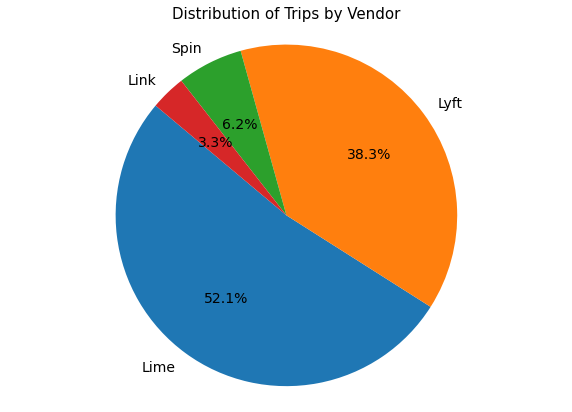

In [19]:
# Generate the pie chart
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.pie(vendor_counts, labels=vendor_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Distribution of Trips by Vendor', fontsize = 15)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the chart
plt.show()

### Vendor Distribution Analysis

In [20]:
# Calculate the percentage of trips by each vendor
vendor_distribution = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100
print(vendor_distribution)

Lime    52.110969
Lyft    38.322075
Spin     6.233664
Link     3.333292
Name: Vendor, dtype: float64


In [21]:
df_e_scooter_trips['Start Community Area Name'].value_counts()

Near North Side    479130
Near West Side     409160
Loop               353414
West Town          288500
Lincoln Park       265325
                    ...  
Forest Glen          1788
Burnside             1482
Edison Park          1051
Mount Greenwood       643
Ohare                 496
Name: Start Community Area Name, Length: 77, dtype: int64

We need to prepare data from the df_e_scooter_trips and df_weather datasets. First, we extract relevant features such as the hour of the day and day of the week from the timestamps, and merge the e-scooter data with weather conditions.

In [22]:
# Count variable added
df_e_scooter_trips['eda_count'] = 1

In [23]:
# Correct datetime format to match the date strings
datetime_format = '%m/%d/%Y %I:%M:%S %p'  # Adjusting to match "MM/DD/YYYY HH:MM:SS AM/PM"

# Convert 'Start Time' and 'End Time' to datetime using the correct format
df_e_scooter_trips['Start Time'] = pd.to_datetime(df_e_scooter_trips['Start Time'], format=datetime_format)
df_e_scooter_trips['End Time'] = pd.to_datetime(df_e_scooter_trips['End Time'], format=datetime_format)

# Extract hour of day and day of the week
df_e_scooter_trips['hour_of_day'] = df_e_scooter_trips['Start Time'].dt.hour
df_e_scooter_trips['day_of_week'] = df_e_scooter_trips['Start Time'].dt.dayofweek
df_e_scooter_trips['is_weekend'] = df_e_scooter_trips['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

In [24]:
# Ensure it's datetime format
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Prepare df_e_scooter_trips for merging
df_e_scooter_trips['date_for_merge'] = df_e_scooter_trips['Start Time'].dt.normalize()

# Perform the merge
df_e_scooter_trips = pd.merge(df_e_scooter_trips, df_weather, left_on='date_for_merge', right_on='datetime', how='left')

# Drop the temporary merging column
df_e_scooter_trips.drop('date_for_merge', axis=1, inplace=True)

### Type of riders partition

In [25]:
from itertools import chain

# Type of riders
# Dictionary for time segments
time_segments = {
    'Morning Commutes': range(5, 11),  # 5 AM to 10 AM
    'Lunchtime Travelers': range(11, 16),  # 10 AM to 3 PM
    'Afternoon Riders': range(16, 21),  # 3 PM to 8 PM
    'Late Night Riders': list(chain(range(21, 24), range(0, 1)))  # 8 PM to Midnight to 1 AM
}

# Lambda function to segment the times
df_e_scooter_trips['type_of_rider'] = df_e_scooter_trips['hour_of_day'].apply(lambda x: next((segment for segment, hours in time_segments.items() if x in hours), None))

# Group by segment and sum the counts
segmented_data = df_e_scooter_trips.groupby('type_of_rider')['eda_count'].sum().reset_index()
sorted_segmented_data = segmented_data.sort_values(by = 'eda_count')
sorted_segmented_data

,type_of_rider,eda_count
3,Morning Commutes,564087
1,Late Night Riders,587900
2,Lunchtime Travelers,1068504
0,Afternoon Riders,1576550


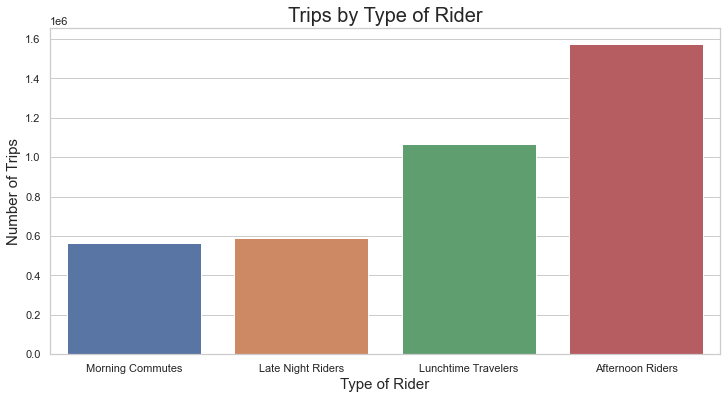

In [26]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'type_of_rider', y = 'eda_count', data = sorted_segmented_data)

# Labels and titles
plt.title('Trips by Type of Rider', fontsize = 20)
plt.xlabel('Type of Rider', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

In [27]:
df_e_scooter_trips_plot = df_e_scooter_trips.groupby('hour_of_day').sum().reset_index()
df_e_scooter_trips_plot.head()

,hour_of_day,Trip Distance,Trip Duration,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,eda_count,day_of_week,is_weekend,temp,precip,snow
0,0,132616397,47345621,1291093.0,1285752.0,2.197761e+06,-4.599212e+06,2.198108e+06,-4.599992e+06,52513,191371,23334,3653104.1,6192.805,168.0
1,1,278601,123792,2558.0,2559.0,4.188226e+03,-8.768162e+03,4.187877e+03,-8.767900e+03,100,306,33,6761.8,4.506,0.0
2,2,2411890,71043,1103.0,1125.0,1.549065e+03,-3.244520e+03,1.549037e+03,-3.244431e+03,38,145,19,2566.9,3.662,0.0
3,3,74786,35927,787.0,767.0,1.088637e+03,-2.280467e+03,1.088677e+03,-2.280416e+03,26,111,15,1742.4,0.847,0.0
4,4,123865,58085,787.0,814.0,1.340901e+03,-2.806448e+03,1.340906e+03,-2.806750e+03,32,102,11,2163.2,0.542,0.0


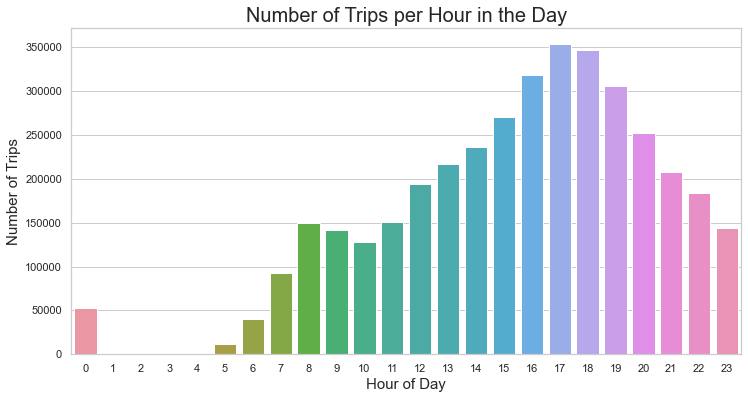

In [28]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'hour_of_day', y = 'eda_count', data = df_e_scooter_trips_plot)

# Labels and titles
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

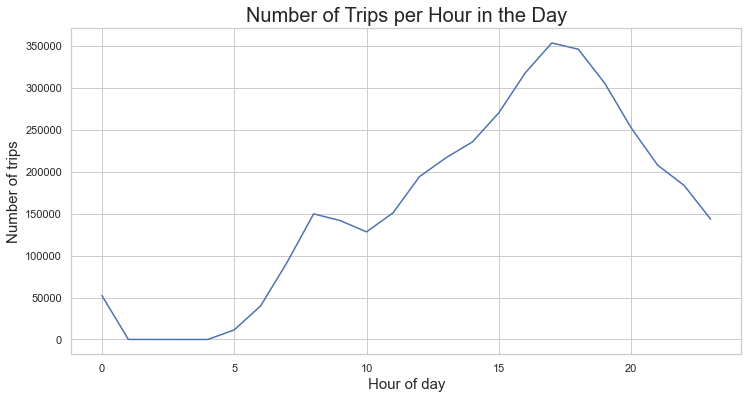

In [29]:
# Line plot
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

graph1 = sns.lineplot(x = 'hour_of_day', y = 'eda_count', data = df_e_scooter_trips_plot)

# Titles and labels
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of day', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)

plt.show()

Demand per Area and Time:
   Start Community Area Name  hour_of_day  demand_count
0                Albany Park            0           419
1                Albany Park            4             1
2                Albany Park            5            78
3                Albany Park            6           227
4                Albany Park            7           624
5                Albany Park            8           944
6                Albany Park            9           945
7                Albany Park           10           936
8                Albany Park           11          1100
9                Albany Park           12          1176
10               Albany Park           13          1341
11               Albany Park           14          1582
12               Albany Park           15          2052
13               Albany Park           16          2020
14               Albany Park           17          2049
15               Albany Park           18          1912
16               Alban

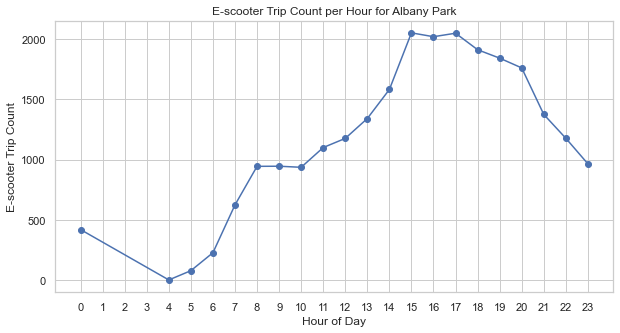

In [30]:
# Ensure all necessary columns are present
if 'Start Community Area Name' in df_e_scooter_trips.columns:
    # Group by community area and hour to aggregate trip counts
    demand_per_area_time = df_e_scooter_trips.groupby(['Start Community Area Name', 'hour_of_day']).size().reset_index(name='demand_count')

    # Sorting the results for better readability
    demand_per_area_time = demand_per_area_time.sort_values(by=['Start Community Area Name', 'hour_of_day'])

    # Display the demand data
    print("Demand per Area and Time:")
    print(demand_per_area_time.head(50))  # Adjust the number to display more or fewer rows as needed
else:
    print("The column 'Start Community Area Name' does not exist in the dataset.")

# For demonstration, visualize the first community area's data
first_area_name = demand_per_area_time['Start Community Area Name'].iloc[0]
area_data = demand_per_area_time[demand_per_area_time['Start Community Area Name'] == first_area_name]

plt.figure(figsize=(10, 5))
plt.plot(area_data['hour_of_day'], area_data['demand_count'], marker='o')
plt.title(f'E-scooter Trip Count per Hour for {first_area_name}')
plt.xlabel('Hour of Day')
plt.ylabel('E-scooter Trip Count')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-axis ticks to show every hour
plt.show()

## Data Preprocessing

In [31]:
# Group by date and hour to aggregate trip counts
df_e_scooter_trips['date_trips'] = df_e_scooter_trips['Start Time'].dt.floor('H')

In [32]:
hourly_demand = df_e_scooter_trips.groupby('date_trips').size().reset_index(name='trip_count')

In [33]:
hourly_demand

,date_trips,trip_count
0,2022-05-10 09:00:00,4
1,2022-05-10 10:00:00,10
2,2022-05-10 11:00:00,11
3,2022-05-10 12:00:00,3
4,2022-05-10 13:00:00,9
...,...,...
10294,2023-09-30 16:00:00,1531
10295,2023-09-30 17:00:00,1391
10296,2023-09-30 18:00:00,1552
10297,2023-09-30 19:00:00,1407


In [34]:
# Merge weather info into hourly demand df
hourly_demand['date'] = hourly_demand['date_trips'].dt.date  # Extracting just the date for merging
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date  # Making sure it's just the date
hourly_demand = pd.merge(hourly_demand, df_weather, left_on='date', right_on='datetime', how='left')
hourly_demand.drop(['date', 'datetime'], axis=1, inplace=True)

In [35]:
hourly_demand

,date_trips,trip_count,temp,precip,snow
0,2022-05-10 09:00:00,4,80.3,0.0,0.0
1,2022-05-10 10:00:00,10,80.3,0.0,0.0
2,2022-05-10 11:00:00,11,80.3,0.0,0.0
3,2022-05-10 12:00:00,3,80.3,0.0,0.0
4,2022-05-10 13:00:00,9,80.3,0.0,0.0
...,...,...,...,...,...
10294,2023-09-30 16:00:00,1531,70.7,0.0,0.0
10295,2023-09-30 17:00:00,1391,70.7,0.0,0.0
10296,2023-09-30 18:00:00,1552,70.7,0.0,0.0
10297,2023-09-30 19:00:00,1407,70.7,0.0,0.0


### Exogenous variables

In [36]:
# Prepare exogenous variables, for example, temperature and precipitation
exog_vars = hourly_demand[['temp', 'precip', 'snow']]

# Implementing the ARIMAX Model for Demand Forecasting

In [37]:
# Define the ARIMAX model
model = SARIMAX(hourly_demand['trip_count'],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                exog=exog_vars,
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit(disp=False)

# Print out the summary of the model's performance
print(results.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         trip_count   No. Observations:                10299
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -61725.618
Date:                            Thu, 30 May 2024   AIC                         123467.236
Time:                                    02:02:21   BIC                         123525.134
Sample:                                         0   HQIC                        123486.808
                                          - 10299                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           6.3441      0.182     34.904      0.000       5.988       6.700
precip      -129.0609      4.069   

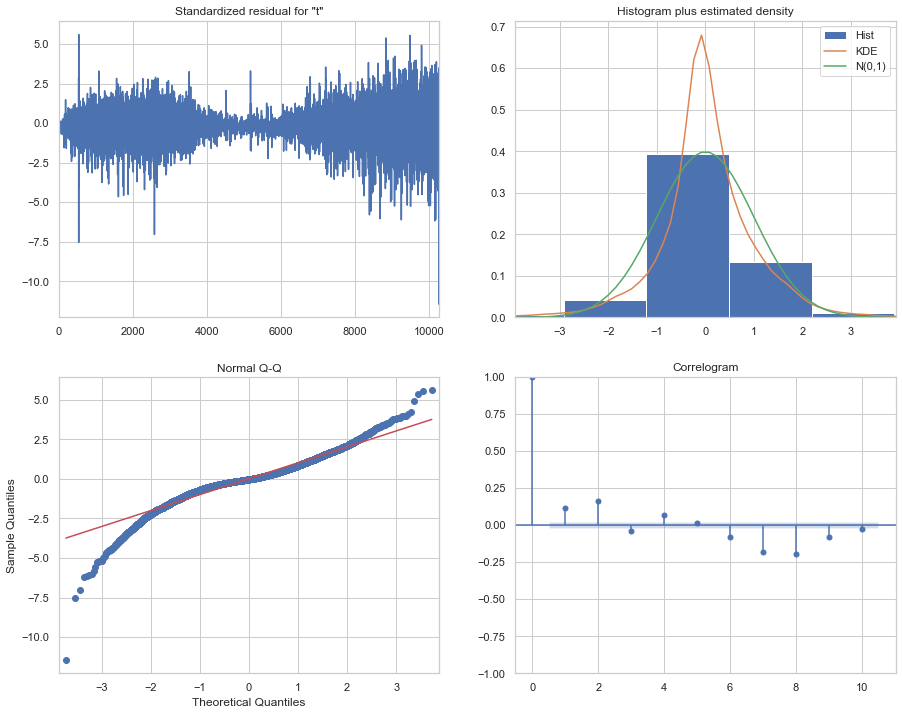

trip_count        mean     mean_se  mean_ci_lower  mean_ci_upper
10299      -574.913674   97.770236    -766.539815    -383.287532
10300      -479.708462  172.434883    -817.674622    -141.742301
10301      -381.175331  213.761533    -800.140237      37.789575
10302      -301.830854  241.495478    -775.153294     171.491586
10303      -236.443094  261.358981    -748.697285     275.811096
10304      -177.668107  276.062226    -718.740128     363.403914
10305      -105.787167  287.161058    -668.612498     457.038164
10306        14.255407  295.646270    -565.200634     593.711448
10307        70.128560  302.190148    -522.153246     662.410366
10308       110.630347  307.268272    -491.604399     712.865094
10309       147.370403  311.226866    -462.623046     757.363851
10310       190.583306  314.323180    -425.478808     806.645419
10311       213.287139  316.751224    -407.533851     834.108130
10312       226.252106  318.658935    -398.307930     850.812141
10313       233.893364  3

In [38]:
# Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
forecast = results.get_forecast(steps=24, exog=exog_vars[-24:])
print(forecast.summary_frame())

# LSTM

## Preparing Data for LSTM

In [39]:
# Prepare dataset for LSTM
data = hourly_demand.set_index('date_trips')['trip_count'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split into train and test sets
look_back = 3  # Number of past hours to use for forecasting
X, y = create_dataset(data_scaled, look_back)
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build and Tune LSTM Model

In [40]:
# Define the LSTM model architecture as a hypermodel
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            input_shape=self.input_shape
        ))
        model.add(Dense(1, activation='linear'))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='mean_squared_error'
        )
        return model

# Instantiate the hypermodel
input_shape = (X_train.shape[1], 1)  # Adjust based on your input feature shape
hypermodel = LSTMHyperModel(input_shape)

# Run random search
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_e_scooter'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

C:\Users\tab\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\tab\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\tab\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## LSTM Evaluation

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Test Loss: 0.00554019445553422
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


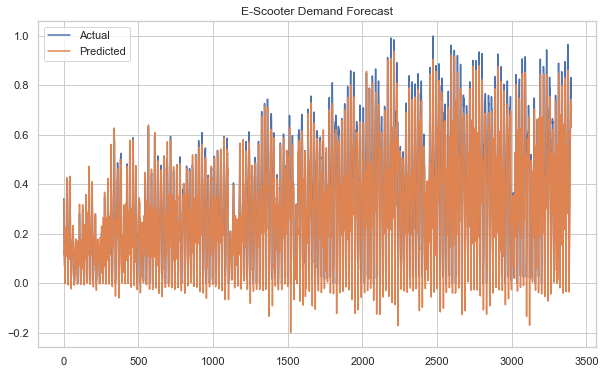

In [41]:
# Evaluate on the test data
test_loss = best_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Optionally, predict and plot predictions
predictions = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('E-Scooter Demand Forecast')
plt.legend()
plt.show()